# Scenario "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation"



| Data Set | Train trjectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |



## Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine ñ i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

| Column| Train trjectories | 
|----------|:-----------------|
| 1    |        unit number        |   
| 2    |        time, in cycles        |     
| 3    |        operational setting 1        |   
| 4    |        operational setting 2        |             
| 5    |        operational setting 3        |           
| 6    |        sensor measurement  1        |              
| 7    |        sensor measurement  2        |             
| 26   |        sensor measurement  3        |              


References: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008., retrieved feb. 2016
2. NASA Ames Prognostics data repository, retrieved feb. 2016, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/
3. [Major Challenges in Prognostics: Study on Benchmarking Prognostics Datasets](https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2012/phmce_12_004.pdf), O. F. Eker1, F. Camci, and I. K. Jennions1, retrieved feb. 2016
4. [Big Data Analytics for eMaintenance : Modeling of high-dimensional data streams.](	
http://goo.gl/kgvoMt) / Zhang, Liangwei.
Luleå : Luleå tekniska universitet, 2015. 46 p. (Licentiate thesis / Luleå University of Technology).
Publication: Research › Licentiate thesis, retrieved feb. 2016
5. Microsoft Cortana example with the same dataset, retrieved feb. 2016 [Link](https://gallery.cortanaanalytics.com/Collection/Predictive-Maintenance-Template-3?share=1)
6. H2o.io example with the same dataset, retrieved feb. 2016
[Link](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/python-munging-modeling-pipelines/Munging-Modeling-Pipelines-Using-H2O-Pipelines.ipynb) [Presentation](https://www.youtube.com/watch?v=KqLXFglgNqk)
7. Advanced Analytics with Spark - Patterns for Learning from Data at Scale By Sandy Ryza, Uri Laserson, Sean Owen, Josh Wills. [Link](http://shop.oreilly.com/product/0636920035091.do) [Examples](https://github.com/sryza/aas)



## intuition of solution 

1. Do visual inspection of the data to enable feature extration and algorithm selection 
2. Train Machine learning model (ML) 
3. Run model to predict classes 
4. Ecaluate model with quality metrics 
5. Change weights on features (coeffients) 


![img](https://raw.githubusercontent.com/combient/tedsds/master/images/ML_Classification_Workflow.png?token=AAJNseI3OcRl1KYDV_ahYL1IGnIjagcBks5W9Qa5wA%3D%3D)


![img](https://raw.githubusercontent.com/combient/tedsds/master/images/datatable.png?token=AAJNsecXdg4OgkpYCSV9c3okmgQjzT2gks5W8oqIwA%3D%3D)

### Initiatlize Spark for Python and create an sqlContext

Please note that the next block should only be run once. It will cause an error if run a second time. 
If the error happens, select "Kernel/restart" from the menu bar.

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()   #This line is not always needed....
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sqlContext = SQLContext(sc)

### Set the schema for the data

In [2]:
# Setup the column names of the training file
index_columns_names =  ["id","cycle"]
operational_settings_columns_names = ["setting"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["s"+str(i) for i in range(1,22)]
sensor_measure_meancolumns_names =["a"+str(i) for i in range(1,22)]
sensor_measure_sdeccolumns_names =["sd"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And the name of the to be engineered target variable
dependent_var = ['rul']

### Reads the parquet file that we prepared previously and print a sumary of the data
Make sure you have sucessfully run the script "run_PrepareAllData.sh" 

In [34]:
scaledDF = sqlContext.read.parquet('/share/tedsds/scaleddftrain_FD001')
scaledDF.describe('setting1','s1','a1','sd1','rul', 's7', 's12', 's20').toPandas()

summary               setting1                s1                a1    sd1  \
0   count                  20631             20631             20631  20631   
1    mean  -8.870146866366143E-6  518.669999999999  518.669999999999    0.0   
2  stddev  0.0021873134490151456               0.0               0.0    0.0   
3     min                -0.0087            518.67            518.67    0.0   
4     max                 0.0087            518.67            518.67    0.0   

                  rul                  s7                 s12  \
0               20631               20631               20631   
1  107.80786195530997   553.3677112112839   521.4134700208422   
2    68.8809901772182  0.8850922576634046  0.7375533922096991   
3                   0              549.85              518.69   
4                 361              556.06              523.38   

                   s20  
0                20631  
1    38.81627066065631  
2  0.18074642787366074  
3                38.14  
4                39.43

In [5]:
scaledDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cycle: integer (nullable = true)
 |-- setting1: double (nullable = true)
 |-- setting2: double (nullable = true)
 |-- setting3: double (nullable = true)
 |-- s1: double (nullable = true)
 |-- s2: double (nullable = true)
 |-- s3: double (nullable = true)
 |-- s4: double (nullable = true)
 |-- s5: double (nullable = true)
 |-- s6: double (nullable = true)
 |-- s7: double (nullable = true)
 |-- s8: double (nullable = true)
 |-- s9: double (nullable = true)
 |-- s10: double (nullable = true)
 |-- s11: double (nullable = true)
 |-- s12: double (nullable = true)
 |-- s13: double (nullable = true)
 |-- s14: double (nullable = true)
 |-- s15: double (nullable = true)
 |-- s16: double (nullable = true)
 |-- s17: double (nullable = true)
 |-- s18: double (nullable = true)
 |-- s19: double (nullable = true)
 |-- s20: double (nullable = true)
 |-- s21: double (nullable = true)
 |-- operationmode: integer (nullable = true)
 |-- rul: integer (nullable = 

### Take a random subset of the data
In the next block, we use spark to select a subset of the column in the data and a random subset of rows. The method .toPanda() then gather all the data on the local node and converts it to a panda DataFrame that can be analyze in Python without any reference to Spark.

In [35]:
fraction = 1000.0 / scaledDF.count()
pf = scaledDF.select(dependent_var+operational_settings_columns_names+sensor_measure_columns_names).sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()

### Import and configure Python library for data manipulation and plotting

In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#Show the plots inside the notebook
%matplotlib inline  

sns.set() 

def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)


### Plot a histogram of the distribution of values of a column and the corresponding kernel density estimate on the same plot

See https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.distplot.html

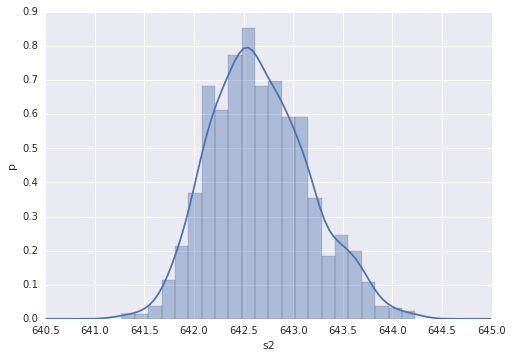

In [47]:
ax = sns.distplot(pf[["s2"]])
labels("s2", "p", ax)

### Calculate correlations between each pairs of columns in the sub-sampled data  and plot it

In [12]:
pf_corr = pf.corr(method='pearson')
pf_corr

rul  setting1  setting2  setting3        s1        s2  \
rul       1.000000 -0.004411  0.010606  0.003564  0.013256  0.006243   
setting1 -0.004411  1.000000  0.943682 -0.000047 -0.965654 -0.860310   
setting2  0.010606  0.943682  1.000000 -0.042899 -0.890934 -0.809099   
setting3  0.003564 -0.000047 -0.042899  1.000000  0.142449  0.472363   
s1        0.013256 -0.965654 -0.890934  0.142449  1.000000  0.939601   
s2        0.006243 -0.860310 -0.809099  0.472363  0.939601  1.000000   
s3       -0.018632 -0.772399 -0.752276  0.619940  0.860744  0.981042   
s4       -0.038346 -0.826499 -0.829348  0.541738  0.891165  0.981367   
s5        0.005959 -0.987950 -0.935618  0.090865  0.986673  0.910728   
s6        0.005600 -0.975960 -0.930646  0.178894  0.986722  0.941202   
s7        0.006543 -0.948569 -0.918128  0.292916  0.972705  0.968120   
s8        0.008437 -0.414439 -0.417622  0.905373  0.549232  0.801845   
s9       -0.005649 -0.761099 -0.744682  0.633212  0.852067  0.977654   
s10      -0.005427 -0.815022 -0.875498  0.509048  0.826398  0.912117   
s11      -0.047019 -0.575755 -0.600275  0.805114  0.685184  0.888943   
s12       0.006428 -0.948096 -0.917963  0.294354  0.972425  0.968369   
s13       0.003135 -0.000253 -0.043034  0.999998  0.142619  0.472518   
s14      -0.043573 -0.220818 -0.318665  0.935966  0.322852  0.611338   
s15      -0.031137  0.426914  0.490112 -0.889812 -0.520676 -0.771209   
s16      -0.065649 -0.837755 -0.887381  0.286448  0.804759  0.816449   
s17      -0.020106 -0.775594 -0.755472  0.615262  0.863814  0.982167   
s18       0.008813 -0.413853 -0.417093  0.905652  0.548684  0.801448   
s19       0.003564 -0.000047 -0.042899  1.000000  0.142449  0.472363   
s20       0.011194 -0.959681 -0.921508  0.260914  0.977571  0.961319   
s21       0.011295 -0.959739 -0.921433  0.260811  0.977585  0.961292   

                s3        s4        s5        s6    ...          s12  \
rul      -0.018632 -0.038346  0.005959  0.005600    ...     0.006428   
setting1 -0.772399 -0.826499 -0.987950 -0.975960    ...    -0.948096   
setting2 -0.752276 -0.829348 -0.935618 -0.930646    ...    -0.917963   
setting3  0.619940  0.541738  0.090865  0.178894    ...     0.294354   
s1        0.860744  0.891165  0.986673  0.986722    ...     0.972425   
s2        0.981042  0.981367  0.910728  0.941202    ...     0.968369   
s3        1.000000  0.989625  0.831606  0.876671    ...     0.925307   
s4        0.989625  1.000000  0.874710  0.912968    ...     0.953575   
s5        0.831606  0.874710  1.000000  0.996022    ...     0.977857   
s6        0.876671  0.912968  0.996022  1.000000    ...     0.992550   
s7        0.924766  0.953111  0.978187  0.992743    ...     0.999992   
s8        0.892555  0.839418  0.499750  0.574069    ...     0.665359   
s9        0.997916  0.987345  0.821747  0.868168    ...     0.918897   
s10       0.934852  0.964642  0.838782  0.875901    ...     0.919545   
s11       0.958263  0.932628  0.650027  0.714407    ...     0.792173   
s12       0.925307  0.953575  0.977857  0.992550    ...     1.000000   
s13       0.620088  0.541890  0.091050  0.179075    ...     0.294526   
s14       0.745868  0.704984  0.296856  0.378340    ...     0.486262   
s15      -0.874378 -0.840927 -0.499249 -0.573662    ...    -0.668828   
s16       0.810244  0.862375  0.830011  0.847358    ...     0.865118   
s17       0.998695  0.990307  0.834704  0.879325    ...     0.927319   
s18       0.892250  0.839064  0.499165  0.573516    ...     0.664858   
s19       0.619940  0.541738  0.090865  0.178894    ...     0.294354   
s20       0.911788  0.941839  0.984625  0.996110    ...     0.999036   
s21       0.911713  0.941772  0.984639  0.996111    ...     0.999017   

               s13       s14       s15       s16       s17       s18  \
rul       0.003135 -0.043573 -0.031137 -0.065649 -0.020106  0.008813   
setting1 -0.000253 -0.220818  0.426914 -0.837755 -0.775594 -0.413853   
setting2 -0.043034 -0.318665  0.490112 -0.887381 -0.7

The formula for calculating the [Pearson Correlation][pearson] between two sets of data can be expressed as:

$$r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$

This text is Markdown and rendered as a presentation via the [RISE][rise] Jupyter extension. In addition to basic Markdown, mathematics can be rendered which is useful when talking to a technical audience.

[rise]: https://github.com/damianavila/RISE
[pearson]: https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient

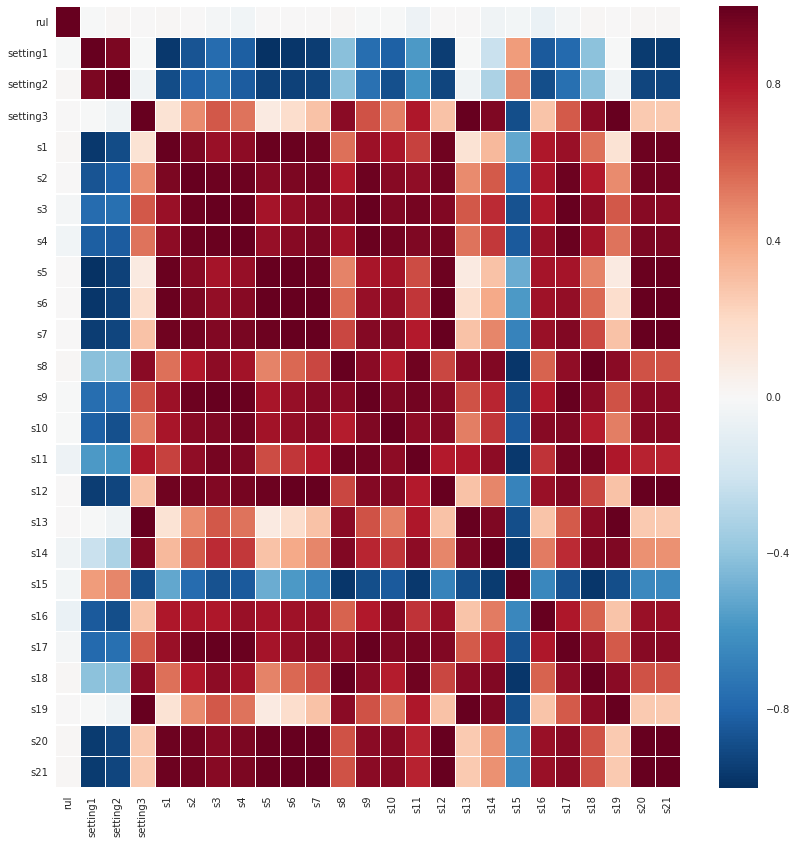

In [13]:
dims = (14,14)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(pf_corr,linewidths=.5);

### Make a closer investigation of some pairs of variables
https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html#seaborn.jointplot

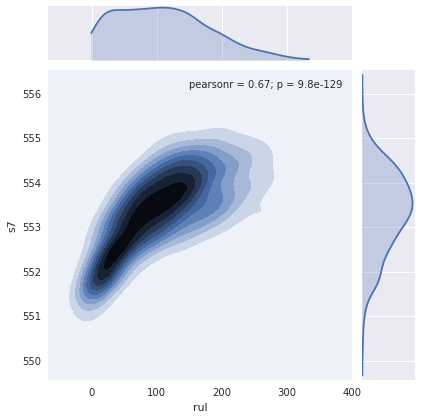

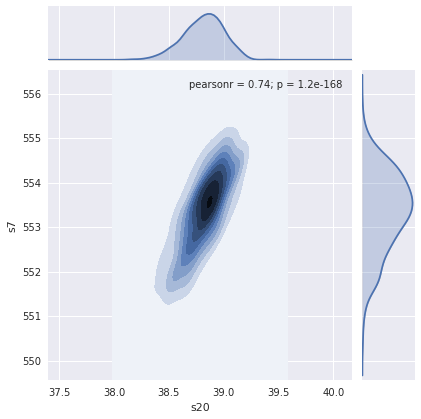

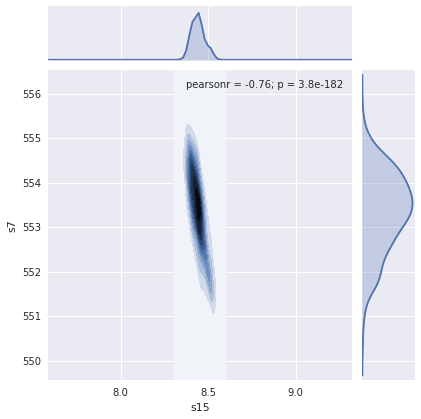

In [52]:
sns.jointplot("rul", "s7", data=pf, kind='kde')  
sns.jointplot("s20", "s7", data=pf, kind='kde')  
sns.jointplot("s15", "s7", data=pf, kind='kde')  

Another way of looking at the same data

https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.JointGrid.html#seaborn.JointGrid

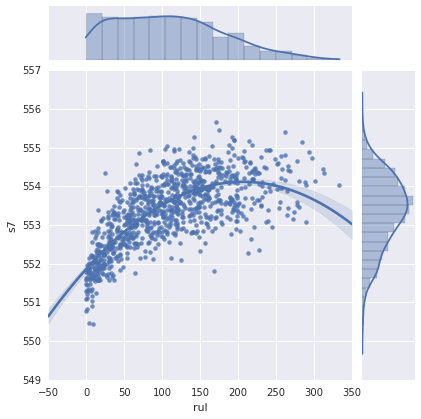

In [53]:
g = sns.JointGrid(x="rul", y="s7", data=pf)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)  

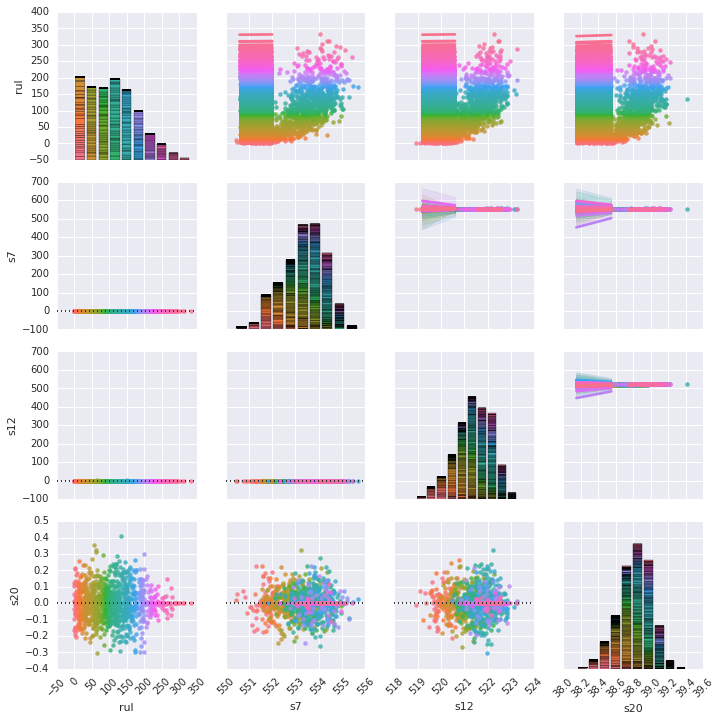

In [54]:
g = sns.PairGrid(pf[["rul", "s7", "s12", "s20"]], hue="rul", dropna=True)  
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(plt.hist)  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
g.set(alpha=0.5)  

# Plot evolution of sensor data over time


In [55]:
fraction = 1000.0 / scaledDF.count()
pf2 = scaledDF.sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()

###Come back to this... To show the time evolution, we need to select a subset of IDs, but have all the cycles for the selected IDs.

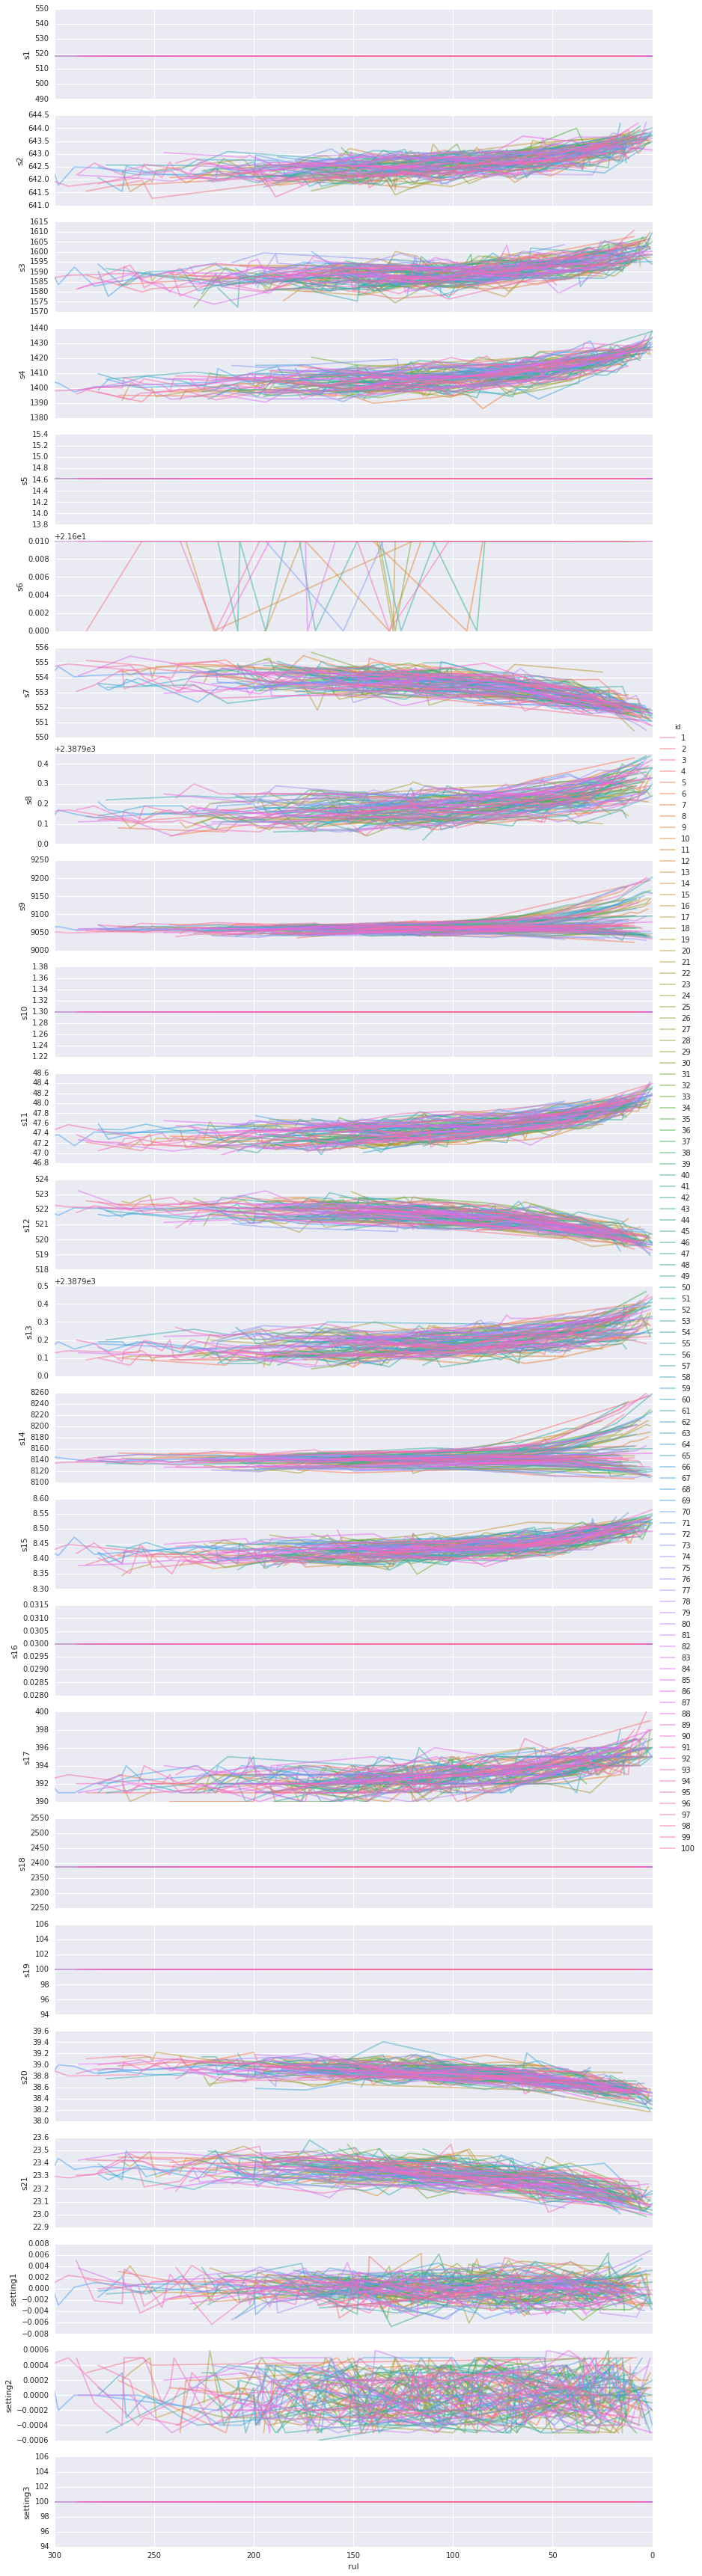

In [64]:

g = sns.PairGrid(data=pf2,
                 x_vars="cycle",
                 y_vars=sensor_measure_columns_names + \
                        operational_settings_columns_names,
                 hue="id", size=2, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

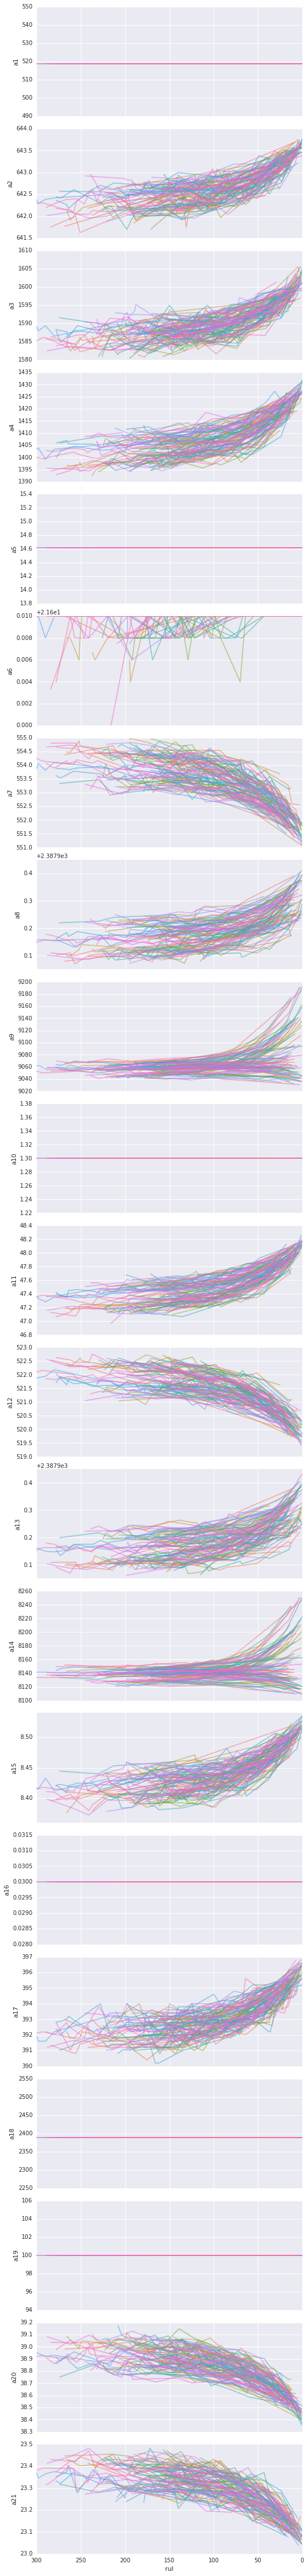

In [62]:
g = sns.PairGrid(data=pf2,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_meancolumns_names,
                 hue="id", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))

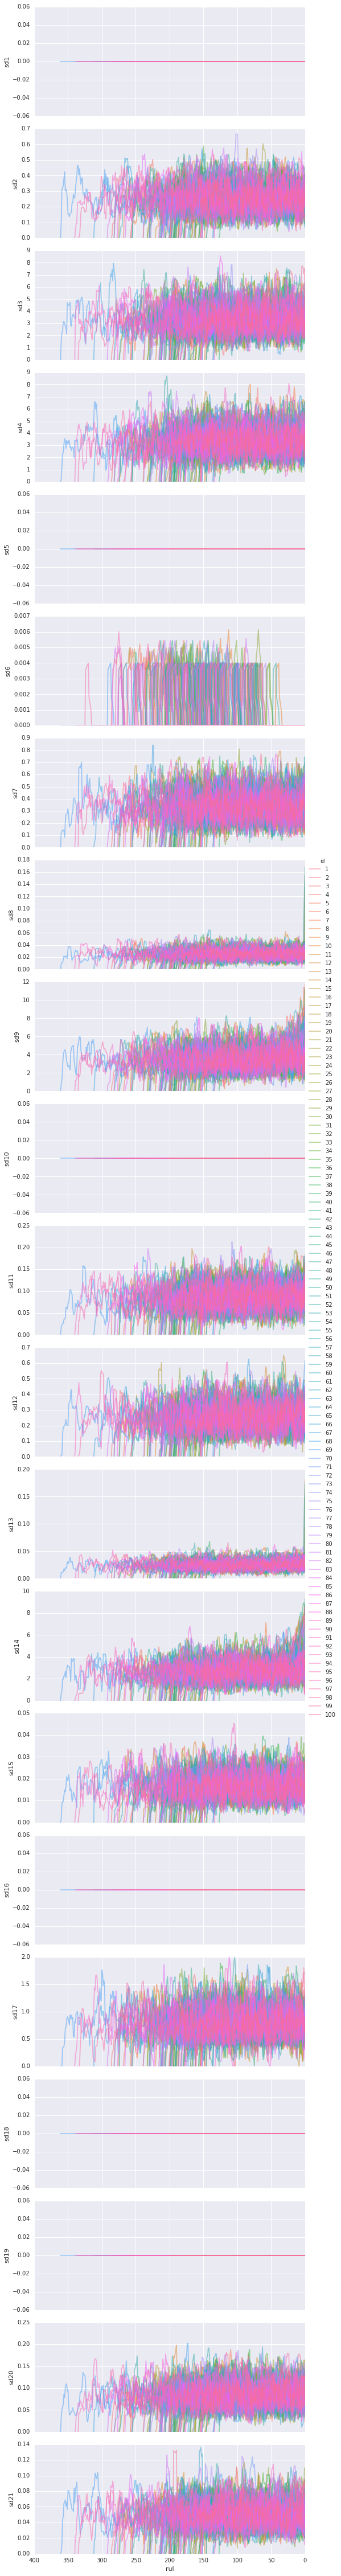

In [63]:

g = sns.PairGrid(data=scaledDF.toPandas(),
                 x_vars=dependent_var,
                 y_vars=sensor_measure_sdeccolumns_names,
                 hue="id", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(400,0))
g = g.add_legend()

# The sensor measurements happen in 6 clusters; this open investigation coincides with the operating modes


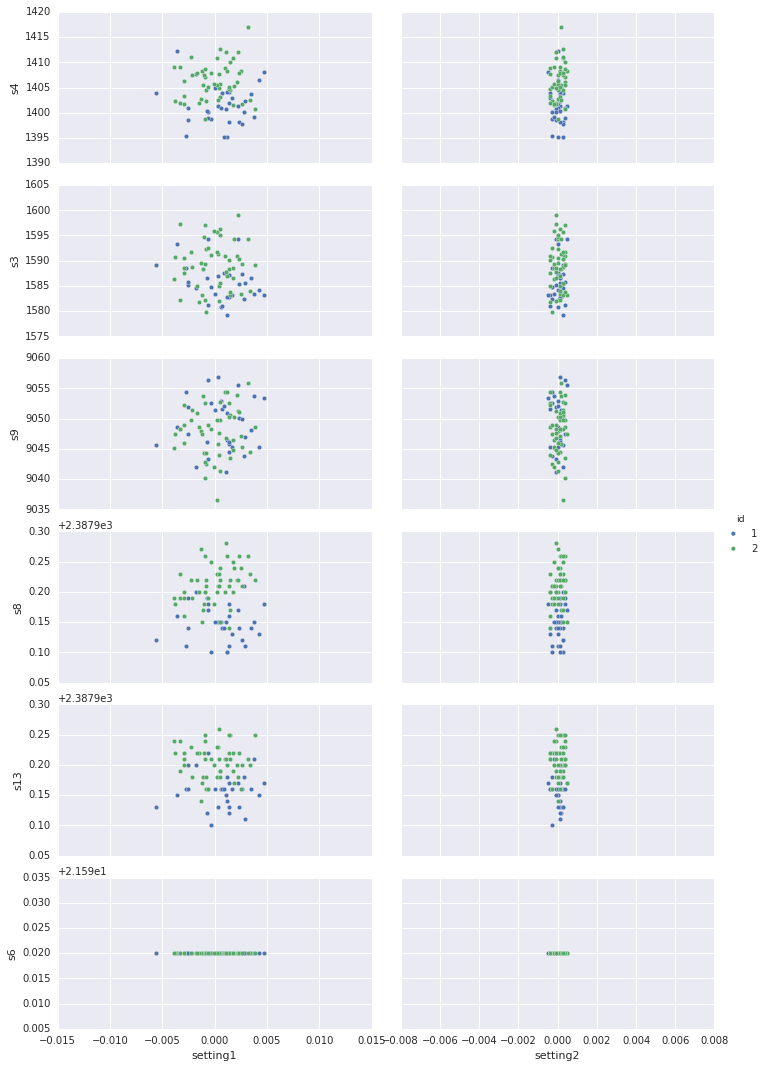

In [19]:

g = sns.pairplot(data=scaledDF.filter(scaledDF.id < 3).toPandas(),
                 x_vars=["setting1","setting2"],
                 y_vars=["s4", "s3", 
                         "s9", "s8", 
                         "s13", "s6"],
                 hue="id", aspect=2)

Use Logistic Regression, [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning version is implemented under [LogisticRegressionWithLBFGS](http://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.mllib.classification.LogisticRegressionWithLBFGS), and this version supports both binary and multinomial Logistic Regression while SGD version only supports binary Logistic Regression. However, L-BFGS version doesn’t support L1 regularization but SGD one supports L1 regularization. When L1 regularization is not required, L-BFGS version is strongly recommended since it converges faster and more accurately compared to SGD by approximating the inverse Hessian matrix using quasi-Newton method.

In [20]:
from pyspark.mllib.linalg import Vectors, DenseMatrix 
import numpy as np

def display_cm(m):
  a = m.toArray()
  #print(a)
  #print(m)
  row_sums = a.astype(np.float64).sum(axis=1).astype(np.float64)
  percentage_matrix = 100.0* a.astype(np.float64) / row_sums[:, np.newaxis]
  #print(percentage_matrix)
  plt.figure(figsize=(3, 3))
  dims = (8,8)
  fig, ax = plt.subplots(figsize=dims)
  sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=['0' ,'1','2'], yticklabels=['0' ,'1','2']);
  plt.title('Confusion Matrix');


In [21]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql import SQLContext



def runmodel(model,data):
    # load the model
    ## trained with one data
    ## trained with all data
    lgregWithLBFGS = LogisticRegressionModel.load(sc, model)
    
    # load data for testset FD001DF 
    scaleddftest_FDDF = sqlContext.read.parquet(data)
    print("scaleddftest_FDDF count = %s" % scaleddftest_FDDF.count())
    
    # Index labels, adding metadata to the label column.
    #Fit on whole dataset to include all labels in index.
    indexer = StringIndexer(inputCol="label2", outputCol="indexedLabel")
    indexedDF = indexer.fit(scaleddftest_FDDF).transform(scaleddftest_FDDF)
    print("indexedDF count = %s" % indexedDF.count())
    labeledRDD = indexedDF.select(col("indexedLabel").alias("label"), col("scaledFeatures").alias("features")).map(lambda row:  LabeledPoint(row.label, row.features))
        
    # Compute raw scores on the test set
    predictionAndLabels = labeledRDD.map(lambda lp: (float(lgregWithLBFGS.predict(lp.features)), lp.label))
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Statistics by class SF
    labels = labeledRDD.map(lambda lp: lp.label).distinct().collect()
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    df_confusion = metrics.confusionMatrix()
    print (df_confusion)
    display_cm(df_confusion);

In [24]:
runmodel("/share/tedsds/savedmodelMulticlassMetricsExamplesaved","/share/tedsds/output")


Py4JJavaError: An error occurred while calling z:org.apache.spark.mllib.classification.LogisticRegressionModel.load.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: hdfs://sandbox.hortonworks.com:8020/share/tedsds/savedmodelMulticlassMetricsExamplesaved/metadata
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:287)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:229)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:315)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:199)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1293)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1288)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1328)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1327)
	at org.apache.spark.mllib.util.Loader$.loadMetadata(modelSaveLoad.scala:129)
	at org.apache.spark.mllib.classification.LogisticRegressionModel$.load(LogisticRegression.scala:175)
	at org.apache.spark.mllib.classification.LogisticRegressionModel.load(LogisticRegression.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


In [ ]:
runmodel("/share/tedsds/savedmodelallMulticlassMetricsExamplesaved","/share/tedsds/scaleddftest_FD001")


Because there are three target category values, this is a 3-×-3 matrix, where each row corresponds to an actual correct value, and each column to a predicted value, in order.  The entry at row i and column j counts the number of times an example with true category i was predicted as category j. So, the correct predictions are the counts along the diagonal, and incorrect predictions are everything else. Counts are high along the diagonal, which is good. However, there are certainly a number of misclassifications. [7]

It’s helpful to summarize the accuracy with a single number. An obvious place to start is to compute the fraction of all examples that were correctly predicted:
   
```
Precision = 0.834012714126
Weighted precision = 0.890728479604

```

About 83% of examples were classified correctly. 

This measurement is commonly called accuracy, and is called precision in Spark’s MulticlassMetrics. This is a light overloading of the term. Precision is actually a common metric for binary classification problems, where there are two category values, not several. In a binary classification problem, where there is some kind of positive and negative class, precision is the fraction of examples that the classifier marked positive that are actually positive. [7]

### What does this mean in this context? 

We are 83% successful in finding when label2 should be 0 (all OK) and 86% successful finding when label2 should be 1 (30 cyckles within breakdown) and 17% successful in telling when label2 should be 2 (15
cyckles within breakdown)

<img src="https://az712634.vo.msecnd.net/samplesimg/v1/T4/labeling_1.png" alt="Drawing" style="width: 400px;"/>



![img](http://dni-institute.in/blogs/wp-content/uploads/2015/02/ConfusionMatrix.png)

In [ ]:
import numpy as np
        
class ROC_Point(object):
    def __init__(self,actual,predicted):
        ''' Method to initialize a ROC Curve with an observation'''
        self.true_positive = 0
        self.true_negative = 0
        self.false_positive= 0
        self.false_negative= 0        
        if actual and predicted:
            self.true_positive = 1
        elif not actual and not predicted:
            self.true_negative = 1
        elif not actual and  predicted:
            self.false_positive= 1
        elif actual and not predicted:
            self.false_negative= 1   
 
    def ROC_add(self, ROC_Point):    
        ''' Method to aggregate ROC Curve'''
        self.true_positive  += ROC_Point.true_positive
        self.true_negative  += ROC_Point.true_negative
        self.false_positive += ROC_Point.false_positive
        self.false_negative += ROC_Point.false_negative
        return self
    def printme(self):
        print 'true_positive ... ' + str(self.true_positive) + '\n'
        print 'true_negative ... ' + str(self.true_negative) + '\n'
        print 'false_positive... ' + str(self.false_positive) + '\n'
        print 'false_negative ...' + str(self.false_negative) + '\n';
 
ROC_Point(True,True) 

def runmodel2(model,data):
    # load the model
    ## trained with one data
    ## trained with all data
    lgregWithLBFGS = LogisticRegressionModel.load(sc, model)
    
    # load data for testset FD001DF 
    scaleddftest_FDDF = sqlContext.read.parquet(data)
    print("scaleddftest_FDDF count = %s" % scaleddftest_FDDF.count())
    
    # Index labels, adding metadata to the label column.
    #Fit on whole dataset to include all labels in index.
    indexer = StringIndexer(inputCol="label2", outputCol="indexedLabel")
    indexedDF = indexer.fit(scaleddftest_FDDF).transform(scaleddftest_FDDF)
    print("indexedDF count = %s" % indexedDF.count())
    labeledRDD = indexedDF.select(col("indexedLabel").alias("label"), col("scaledFeatures").alias("features")).map(lambda row:  LabeledPoint(row.label, row.features))
        
    # Compute raw scores on the test set
    predictionAndLabels = labeledRDD.map(lambda lp: (float(lgregWithLBFGS.predict(lp.features)), lp.label))
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Statistics by class SF
    labels = labeledRDD.map(lambda lp: lp.label).distinct().collect()
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    df_confusion = metrics.confusionMatrix()
    display_cm(df_confusion)
    operating_threshold_bc = sc.broadcast(np.arange(0,1,.001))
    labelsAndPreds_Points = predictionAndLabels.map(lambda (label,prediction):  [ROC_Point(label==1,prediction>threshold)
    for threshold in operating_threshold_bc.value])
    labelsAndPreds_ROC_reduced = labelsAndPreds_Points.reduce( lambda l1,l2:  [ ROC_1.ROC_add(ROC_2) for ROC_1,ROC_2 in zip(l1,l2) ] )
    import matplotlib.pyplot as plt
    plt.plot(x,y,'ro')
    plt.plot(np.arange(0,1,.001),np.arange(0,1,.001), 'g-')
    plt.title('ROC Curve - TP rate vs. FP rate' )
    plt.show()

        


In [ ]:
runmodel2("/share/tedsds/savedmodelallMulticlassMetricsExamplesaved","/share/tedsds/scaleddftrain_FD001")

